## Getting started with initial data exploration

Since this is a new dataset to me, I'm going to need to spend some time just going through it and understanding what I'm looking at.

In [1]:
from pathlib import Path

In [33]:
import altair as alt
import pandas as pd
import cmdstanpy
import arviz as az
import seaborn as sns

In [75]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_theme(style='ticks')


In [3]:
%load_ext cmdstanjupyter

In [4]:
data_dir = Path('../data')

In [5]:
list(data_dir.iterdir())

[PosixPath('../data/washingtondc.csv'),
 PosixPath('../data/south_korea.csv'),
 PosixPath('../data/meteoswiss.csv'),
 PosixPath('../data/kyoto.csv'),
 PosixPath('../data/liestal.csv'),
 PosixPath('../data/USA-NPN_status_intensity_observations_data.csv'),
 PosixPath('../data/japan.csv'),
 PosixPath('../data/USA-NPN_status_intensity_datafield_descriptions.csv'),
 PosixPath('../data/README.md'),
 PosixPath('../data/USA-NPN_individual_phenometrics_datafield_descriptions.csv'),
 PosixPath('../data/.ipynb_checkpoints'),
 PosixPath('../data/USA-NPN_individual_phenometrics_data.csv')]

A good place to start may be just the main location observations, which include Washington DC, Kyoto, Japan, and Liestal, Switzerland:

In [6]:
locations = ['washingtondc', 'kyoto', 'liestal']

In [7]:
df = pd.concat(pd.read_csv(file) for file in data_dir.glob('*csv') 
               if file.stem in locations)

In [8]:
df

,location,lat,long,alt,year,bloom_date,bloom_doy
0,washingtondc,38.88535,-77.038628,0,1921,1921-03-20,79
1,washingtondc,38.88535,-77.038628,0,1922,1922-04-07,97
2,washingtondc,38.88535,-77.038628,0,1923,1923-04-09,99
3,washingtondc,38.88535,-77.038628,0,1924,1924-04-13,104
4,washingtondc,38.88535,-77.038628,0,1925,1925-03-27,86
...,...,...,...,...,...,...,...
123,liestal,47.48140,7.730519,350,2017,2017-03-26,85
124,liestal,47.48140,7.730519,350,2018,2018-04-08,98
125,liestal,47.48140,7.730519,350,2019,2019-03-27,86
126,liestal,47.48140,7.730519,350,2020,2020-03-17,77


In [9]:
alt.Chart(df[df.year > 1920]).mark_line().encode(x='year:O', y='bloom_doy', color='location').properties(width=1200)

alt.Chart(...)

First thing that jumps around to me is there is a good deal of variance around the observed dates across the board. Let's take a look at just DC to see if there are any 
obvious trends:

In [10]:
dc_obs_chart = alt.Chart(df[(df.year > 1920) & (df.location == 'washingtondc')]).mark_point().encode(x='year:O', y='bloom_doy', color='location').properties(width=1200)
dc_obs_chart

alt.Chart(...)

If you squint a bit, it looks like the peak bloom date for DC has gotten a bit lower over time, but it's hard to really see the trend from the noise. How does the moving average look?

In [11]:
dc_bloom_days = df[df.location == 'washingtondc'][['year', 'bloom_doy']].copy()

In [12]:
dc_obs_chart_ma = alt.Chart(dc_bloom_days.rolling(5).mean().dropna().astype(int)).mark_line().encode(x='year:N', y='bloom_doy')

In [13]:
dc_obs_chart + dc_obs_chart_ma

alt.LayerChart(...)

It looks like _maybe_ the average has dipped over the years, but you see it not being consistent. Nothing particularly unprecedented more recently.

Let's throw together a basic AR(1) model and see what pops out.

In [14]:
%%stan ar_1_model
data {
  int<lower=1> N; // obs
  vector[N] Y;
}
parameters {
  real alpha;
  real<lower=0> sigma;
}
model {
  alpha ~ std_normal();
  sigma ~ exponential(2);
  
  for (n in 2:N)
    Y[n] ~ normal(alpha*Y[n-1], sigma);
}
generated quantities {
  vector[N] Y_rep;
  Y_rep[1] = Y[1];
  for (n in 2:N)
    Y_rep[n] = normal_rng(alpha*Y_rep[n-1], sigma);
}

INFO:cmdstanjupyter:Writing model to .stan/ar_1_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "ar_1_model"
INFO:cmdstanpy:compiling stan file /home/amas/projects/peak-bloom-prediction/analysis/.stan/ar_1_model.stan to exe file /home/amas/projects/peak-bloom-prediction/analysis/.stan/ar_1_model
INFO:cmdstanpy:compiled model executable: /home/amas/projects/peak-bloom-prediction/analysis/.stan/ar_1_model
INFO:cmdstanjupyter:StanModel now available as variable "ar_1_model"!
 Compilation took 7 seconds.


In [15]:
dc_bloom_days

,year,bloom_doy
0,1921,79
1,1922,97
2,1923,99
3,1924,104
4,1925,86
...,...,...
96,2017,84
97,2018,95
98,2019,91
99,2020,80


In [16]:
data = {'N': len(dc_bloom_days), 'Y': dc_bloom_days.bloom_doy.astype(float).values}

In [17]:
fit_ar_1 = ar_1_model.sample(data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [18]:
fit_ar_1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-290.0,0.02400,1.000000e+00,-290.00,-290.0,-290.0,1700.0,3100.0,1.0
alpha,1.0,0.00017,9.500000e-03,0.98,1.0,1.0,3100.0,5700.0,1.0
sigma,8.8,0.01000,5.600000e-01,7.90,8.8,9.8,2900.0,5300.0,1.0
Y_rep[1],79.0,NaN,8.000000e-13,79.00,79.0,79.0,NaN,NaN,NaN
Y_rep[2],79.0,0.14000,8.800000e+00,64.00,79.0,93.0,4055.0,7372.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_rep[97],78.0,2.10000,1.230000e+02,-59.00,53.0,296.0,3311.0,6020.0,1.0
Y_rep[98],78.0,2.20000,1.250000e+02,-59.00,52.0,300.0,3307.0,6012.0,1.0
Y_rep[99],78.0,2.20000,1.260000e+02,-60.00,52.0,303.0,3303.0,6006.0,1.0


In [27]:
az_1 = az.from_cmdstanpy(posterior=fit_ar_1, posterior_predictive='Y_rep',
                         observed_data={'Y': data['Y']})

In [26]:
az_1

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [24]:
az.summary(az_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.996,0.010,0.977,1.013,0.00,0.000,3170.0,2198.0,1.0
sigma,8.829,0.559,7.780,9.872,0.01,0.007,2942.0,2543.0,1.0


In [39]:
pp_samples = fit_ar_1.draws_pd('Y_rep').sample(50).reset_index().melt(id_vars='index')
pp_samples['year'] = 1920 + pp_samples.variable.str.extract(r'(\d+)').astype(int)

<AxesSubplot:xlabel='year', ylabel='value'>

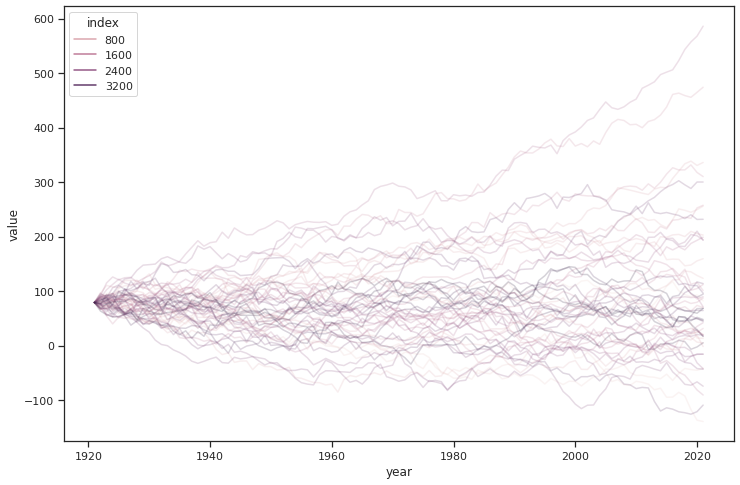

In [76]:
sns.lineplot(x='year', y='value', hue='index', alpha=0.2, data=pp_samples)

Way too much uncertainty from the random walk. Maybe better to model it as random dispersion around a true mean.

<AxesSubplot:xlabel='bloom_doy', ylabel='Count'>

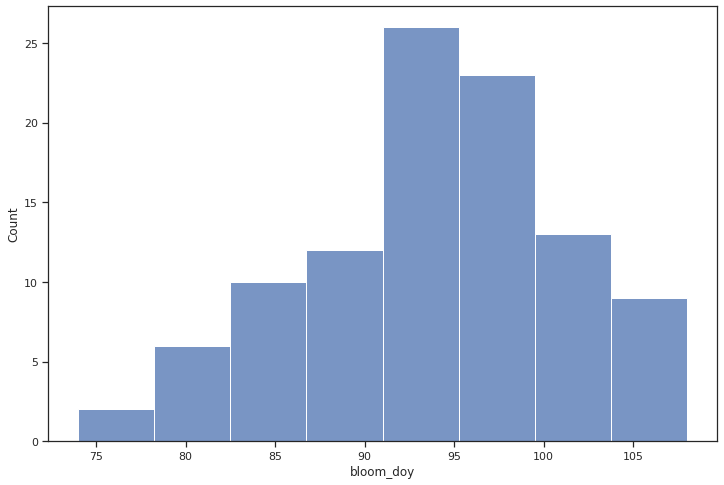

In [80]:
sns.histplot(dc_bloom_days.bloom_doy)

In [97]:
%%stan mean_2_model
data {
  int<lower=1> N; // obs
  vector[N] Y;
}
transformed data {
  vector[N] Y_norm = (Y - mean(Y)) / sd(Y);
}
parameters {
  real alpha;
  real<lower=0> sigma;
}
model {
  alpha ~ std_normal();
  sigma ~ exponential(2);
  
  Y_norm ~ normal(alpha, sigma);
}
generated quantities {
  vector[N] Y_rep;
  vector[N] log_lik;
  for (n in 1:N) {
    Y_rep[n] = (normal_rng(alpha, sigma))*sd(Y) + mean(Y);
    log_lik[n] = normal_lpdf(Y_norm[n] | alpha, sigma);
  }
}

INFO:cmdstanjupyter:Writing model to .stan/mean_2_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "mean_2_model"
INFO:cmdstanpy:compiling stan file /home/amas/.cmdstan/cmdstan-2.28.2/.stan/mean_2_model.stan to exe file /home/amas/.cmdstan/cmdstan-2.28.2/.stan/mean_2_model
INFO:cmdstanpy:compiled model executable: /home/amas/.cmdstan/cmdstan-2.28.2/.stan/mean_2_model
INFO:cmdstanjupyter:StanModel now available as variable "mean_2_model"!
 Compilation took 8 seconds.


In [98]:
fit_2 = mean_2_model.sample(data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [102]:
az_2 = az.from_cmdstanpy(fit_2, posterior_predictive='Y_rep',
                         observed_data={'Y': data['Y']}, log_likelihood='log_lik')

In [99]:
fit_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-53.0000,0.0240,1.000,-55.00,-53.0000,-52.00,1800.0,2000.0,1.0
alpha,-0.0021,0.0017,0.098,-0.16,-0.0021,0.16,3100.0,3400.0,1.0
sigma,1.0000,0.0013,0.073,0.89,1.0000,1.10,3000.0,3300.0,1.0
Y_rep[1],94.0000,0.1200,7.500,81.00,94.0000,106.00,4165.0,4592.0,1.0
Y_rep[2],94.0000,0.1200,7.400,82.00,93.0000,106.00,3991.0,4400.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[97],-1.8000,0.0025,0.140,-2.00,-1.8000,-1.60,3177.0,3502.0,1.0
log_lik[98],-0.9400,0.0013,0.072,-1.10,-0.9400,-0.83,2934.0,3235.0,1.0
log_lik[99],-0.9900,0.0013,0.073,-1.10,-0.9900,-0.87,3027.0,3337.0,1.0


In [100]:
pp_2_samples = fit_2.draws_pd('Y_rep').sample(1).reset_index().melt(id_vars='index')
pp_2_samples['year'] = 1920 + pp_2_samples.variable.str.extract(r'(\d+)').astype(int)

<AxesSubplot:xlabel='year', ylabel='value'>

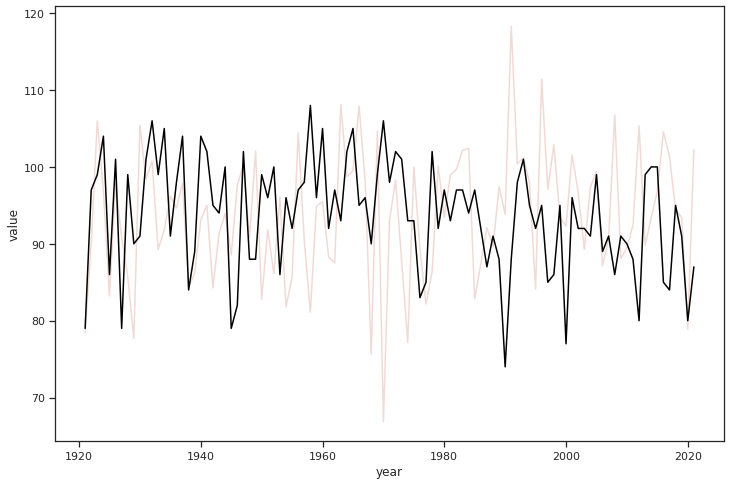

In [101]:
sns.lineplot(x='year', y='value', hue='index', alpha=0.8, data=pp_2_samples, legend=False)
sns.lineplot(x='year', y='bloom_doy', data=dc_bloom_days, color='black')

This certainly "fits" in the sense that the variation looks relatively plausible, but there's not really much interest to a model that is "random normal sampling". Let's add an AR(1) parameter to see if that does anything for us.

In [103]:
%%stan model_3
data {
  int<lower=1> N; // obs
  vector[N] Y;
}
transformed data {
  vector[N] Y_norm = (Y - mean(Y)) / sd(Y);
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ std_normal();
  beta ~ std_normal();
  sigma ~ exponential(2);
  
  for (n in 2:N)
    Y_norm[n] ~ normal(alpha + beta*Y_norm[n-1], sigma);
}
generated quantities {
  vector[N] Y_rep;
  vector[N] log_lik;
  Y_rep[1] = (normal_rng(alpha, sigma))*sd(Y) + mean(Y);
  log_lik[1] = normal_lpdf(Y_norm[1] | alpha, sigma);
  
  for (n in 2:N) {
    Y_rep[n] = (normal_rng(alpha, sigma))*sd(Y) + mean(Y);
    log_lik[n] = normal_lpdf(Y_norm[n] | alpha + beta*Y_norm[n-1], sigma);
  }
}

INFO:cmdstanjupyter:Writing model to .stan/model_3.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "model_3"
INFO:cmdstanpy:compiling stan file /home/amas/.cmdstan/cmdstan-2.28.2/.stan/model_3.stan to exe file /home/amas/.cmdstan/cmdstan-2.28.2/.stan/model_3
INFO:cmdstanpy:compiled model executable: /home/amas/.cmdstan/cmdstan-2.28.2/.stan/model_3
INFO:cmdstanjupyter:StanModel now available as variable "model_3"!
 Compilation took 8 seconds.


In [104]:
fit_3 = model_3.sample(data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [105]:
az_3 = az.from_cmdstanpy(fit_3, posterior_predictive='Y_rep',
                         observed_data={'Y': data['Y']}, log_likelihood='log_lik')

In [106]:
fit_3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-50.00,0.0300,1.300,-53.000,-50.00,-49.00,1800.0,1600.0,1.0
alpha,0.02,0.0016,0.097,-0.140,0.02,0.18,3800.0,3400.0,1.0
beta,0.13,0.0015,0.097,-0.028,0.14,0.29,4100.0,3700.0,1.0
sigma,0.98,0.0012,0.071,0.870,0.98,1.10,3500.0,3100.0,1.0
Y_rep[1],94.00,0.1100,7.300,82.000,94.00,106.00,4022.0,3630.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[97],-1.60,0.0030,0.190,-2.000,-1.60,-1.40,3992.0,3603.0,1.0
log_lik[98],-0.97,0.0015,0.088,-1.100,-0.97,-0.84,3309.0,2987.0,1.0
log_lik[99],-0.99,0.0012,0.072,-1.100,-0.99,-0.88,3713.0,3351.0,1.0


In [107]:
az.compare({'model_2': az_2, 'model_3': az_3})

/home/amas/.local/lib/python3.10/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/home/amas/.local/lib/python3.10/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-144.755167,1.830873,0.000000,0.552197,6.660249,0.000000,False,log
model_3,1,-144.871738,2.835455,0.116571,0.447803,6.908443,1.362753,False,log


In [113]:
pp_3_samples = fit_3.draws_pd('Y_rep').sample(5).reset_index().melt(id_vars='index')
pp_3_samples['year'] = 1920 + pp_3_samples.variable.str.extract(r'(\d+)').astype(int)

<AxesSubplot:xlabel='year', ylabel='value'>

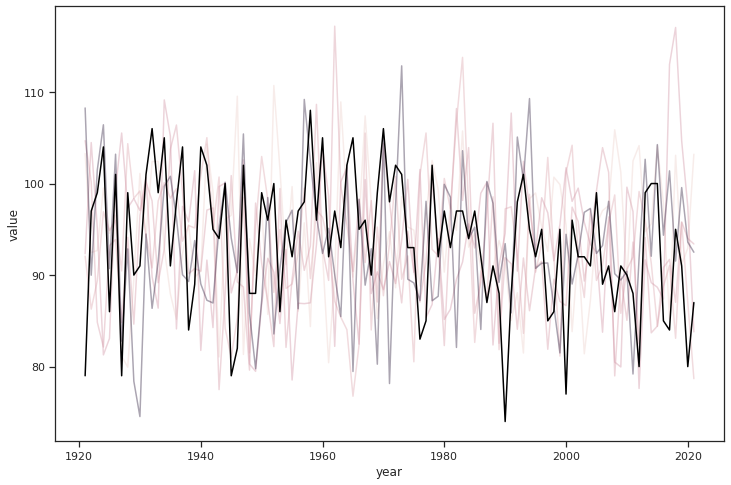

In [114]:
sns.lineplot(x='year', y='value', hue='index', alpha=0.4, data=pp_3_samples, legend=False)
sns.lineplot(x='year', y='bloom_doy', data=dc_bloom_days, color='black')

In [134]:
dc_obs_chart.mark_point(color='black', opacity=1) + alt.Chart(pp_3_samples).mark_line(opacity=0.3).encode(x='year:N', y='value', color='index:N').properties(width=700, height=400) 

alt.LayerChart(...)

In any case, all of the models fit so far either fail to do much of anything, or, just show that _from the data itself_ there is little information that would differentiate it from just random noise. This is a case where some additional information will be necessary. While we haven't looked at the other locations, it would be surprising to see major deviations from this initial
exploration.

For the sake of thinking about longer term trends, let's glimpse at Kyoto's data, which has, by far, the most observations.

In [137]:
kyoto = df.query('location == "kyoto"').copy()

In [171]:
points = alt.Chart(kyoto).mark_point(opacity=0.4).encode(x='year:Q', y='bloom_doy')
line = alt.Chart(kyoto).mark_line(color='orange').transform_window(rolling_mean='mean(bloom_doy)', frame=[-10, 10]).encode(x='year:Q', y='rolling_mean:Q')

In [172]:
(line + points).properties(width=1200)

alt.LayerChart(...)

Okay this data is more interesting, because in the context of a long time frame, it certainly looks like the average peak bloom date has dropped compoared to hundreds of years ago.

Prior knowledge, plus this initial look suggests that climate change, and in particular, the warming of the planet starting in industrial times have resulting in earlier bloom
times.

I think the clear paths forward will be to see if there are any suggestive properties of the climate data, specifically those associated with the onset of Spring, like increased temperature that can be contributing factors to the date of peak bloom.